#  <center> Speech Emotion Recognition <center>

In [51]:
# %pip install librosa
# %pip install keras
# %pip install tensorflow
# %pip install np_utils

import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from librosa.effects import time_stretch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import utils
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [52]:
# %pip install kaggle

# !kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
# # %mkdir destination


In [53]:
# %%sh unzip -o "./ravdess-emotional-speech-audio.zip" -d "./ravdess-emotional-speech-audio"

In [54]:
Ravdess = "./ravdess-emotional-speech-audio/audio_speech_actors_01-24/" # destination address

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        parts = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[7]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  ./ravdess-emotional-speech-audio/audio_speech_...
1     fear  ./ravdess-emotional-speech-audio/audio_speech_...
2     fear  ./ravdess-emotional-speech-audio/audio_speech_...
3    angry  ./ravdess-emotional-speech-audio/audio_speech_...
4  disgust  ./ravdess-emotional-speech-audio/audio_speech_...

In [55]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  ./ravdess-emotional-speech-audio/audio_speech_...
1     fear  ./ravdess-emotional-speech-audio/audio_speech_...
2     fear  ./ravdess-emotional-speech-audio/audio_speech_...
3    angry  ./ravdess-emotional-speech-audio/audio_speech_...
4  disgust  ./ravdess-emotional-speech-audio/audio_speech_...

## Data Visualisation and Exploration

<Axes: title={'center': 'Count of Emotions'}, xlabel='Emotions', ylabel='Count'>

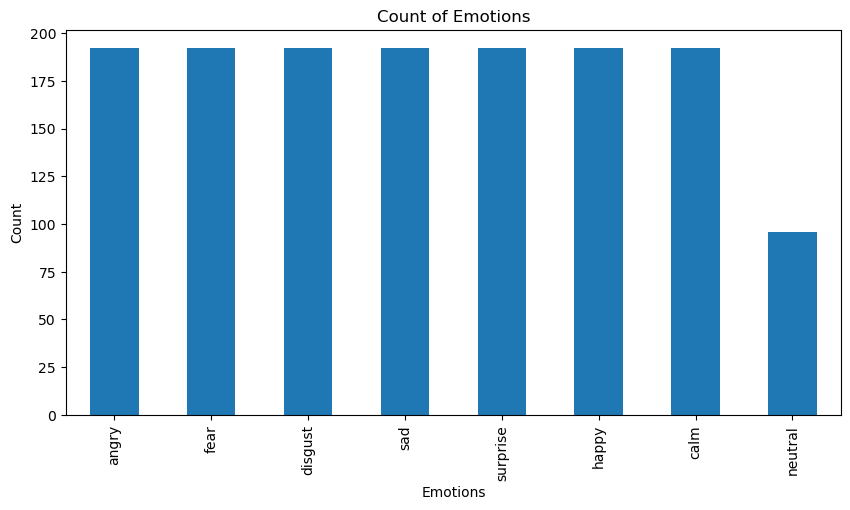

In [56]:
# count of each emotion and its plot
data_path.Emotions.value_counts().plot(kind='bar', title='Count of Emotions', ylabel='Count', xlabel='Emotions', figsize=(10, 5))

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [57]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

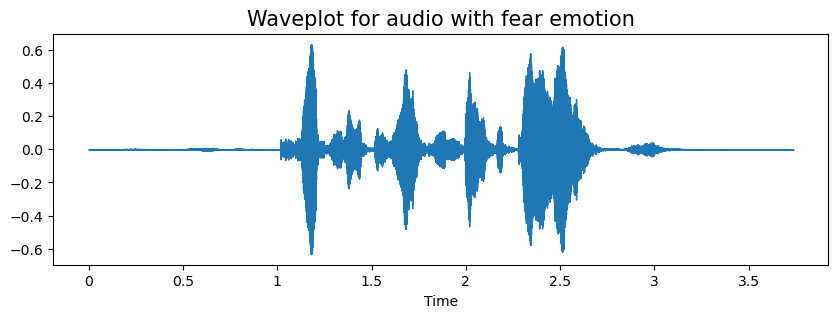

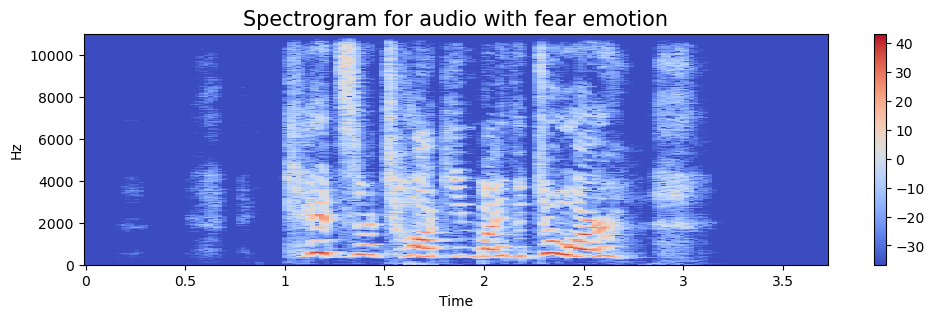

In [58]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

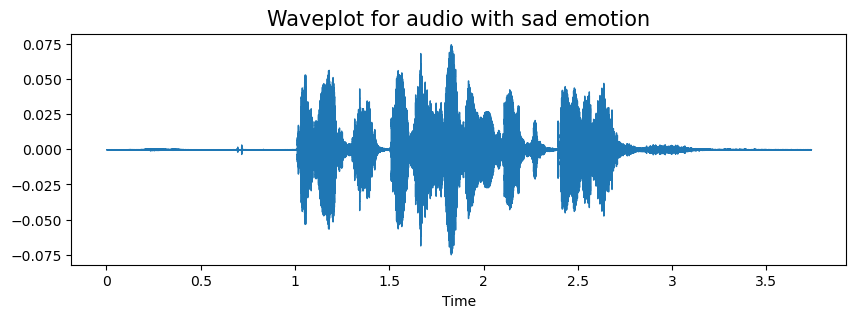

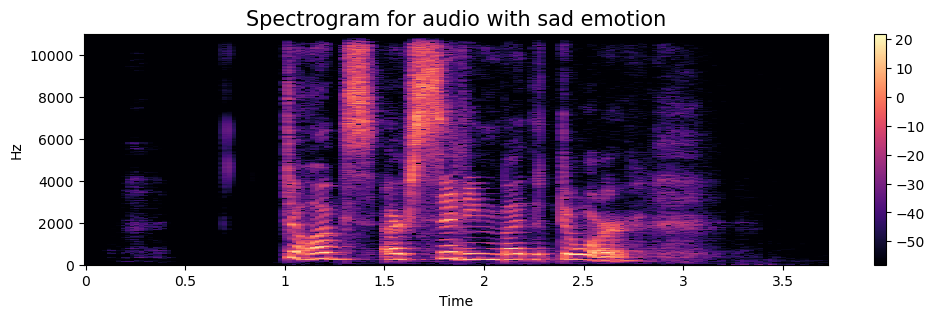

In [59]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

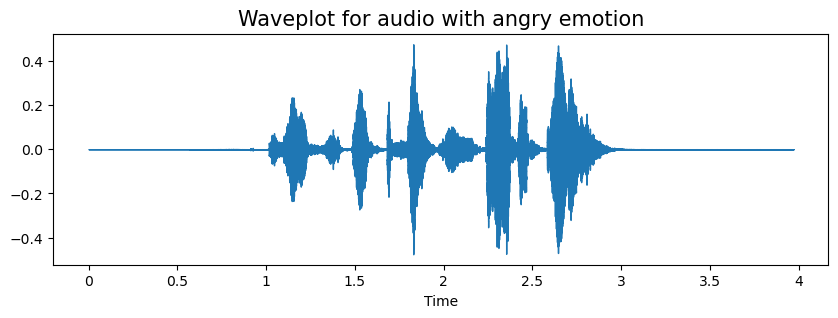

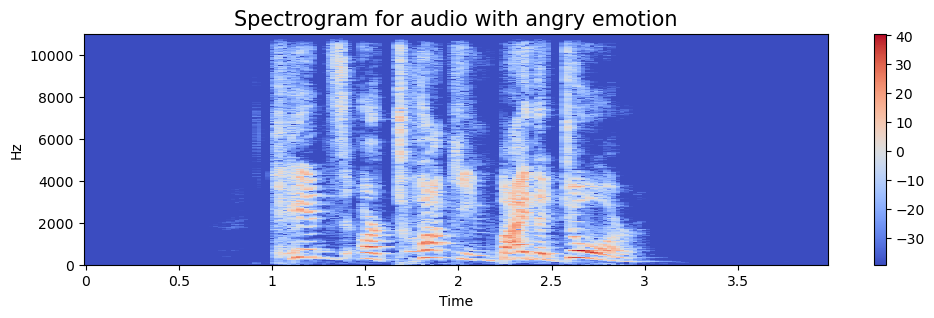

In [60]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

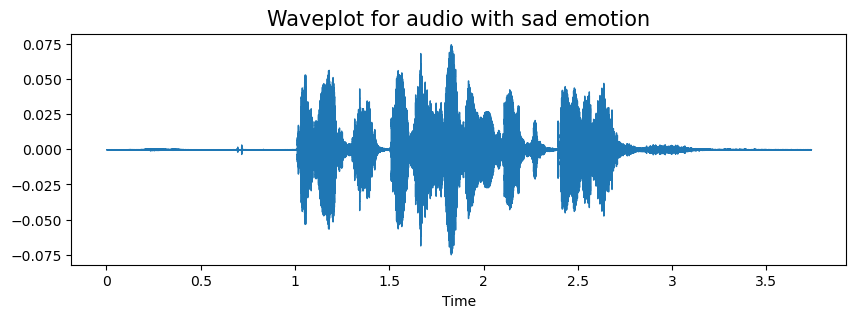

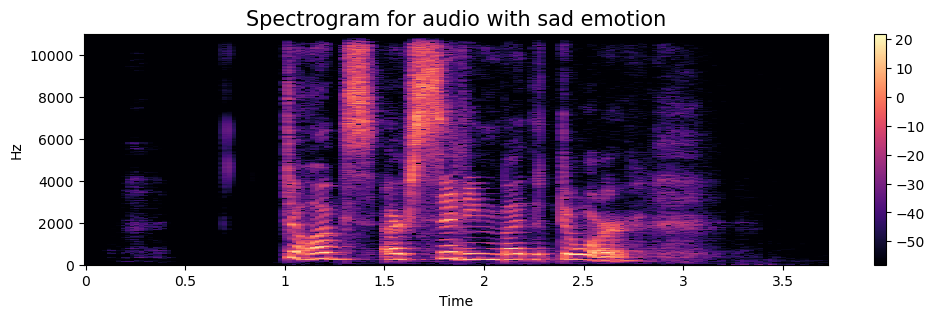

In [61]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

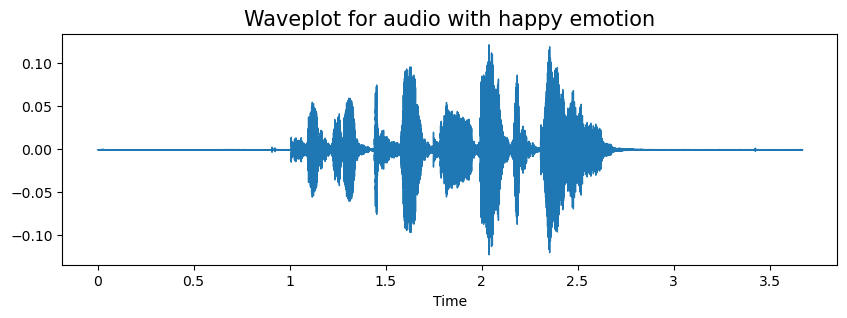

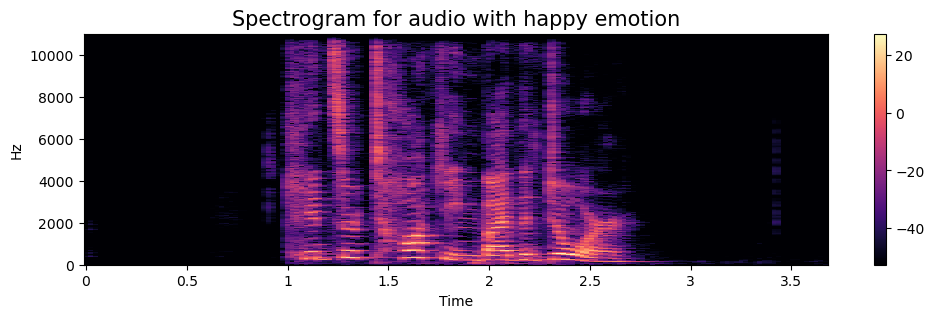

In [62]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [63]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

print(sample_rate)


22050


#### 1. Simple Audio

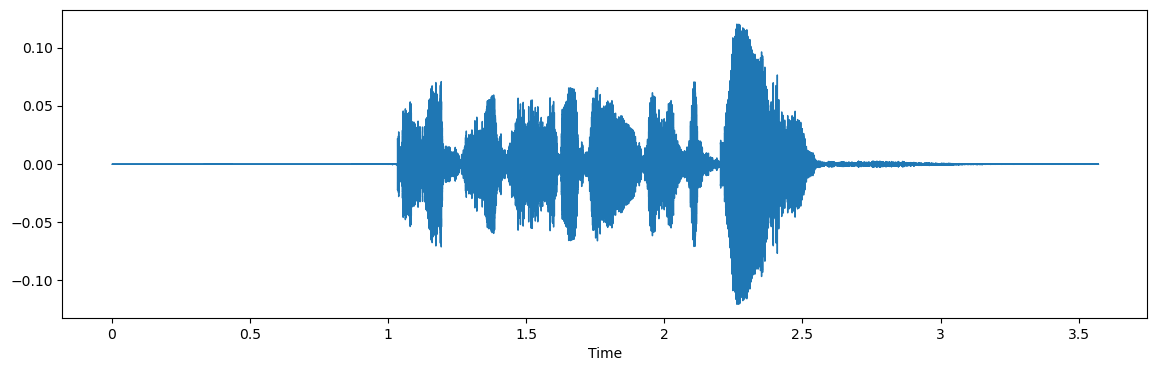

In [64]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

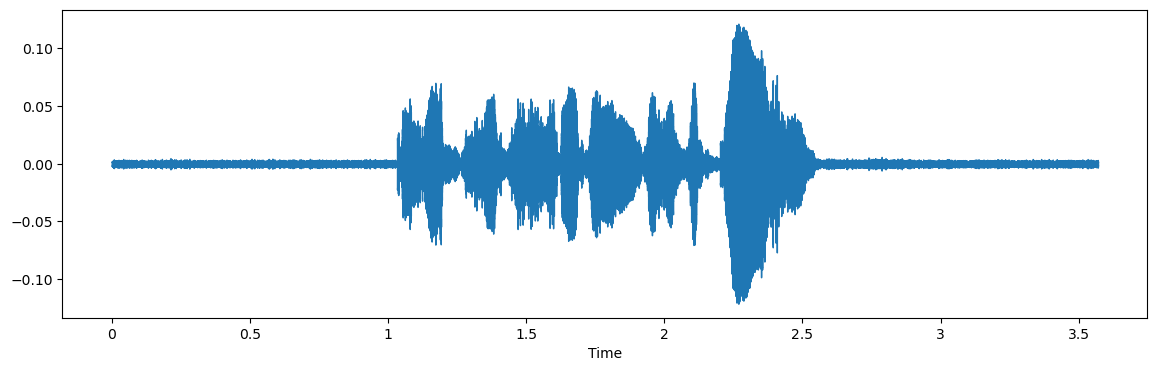

In [65]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

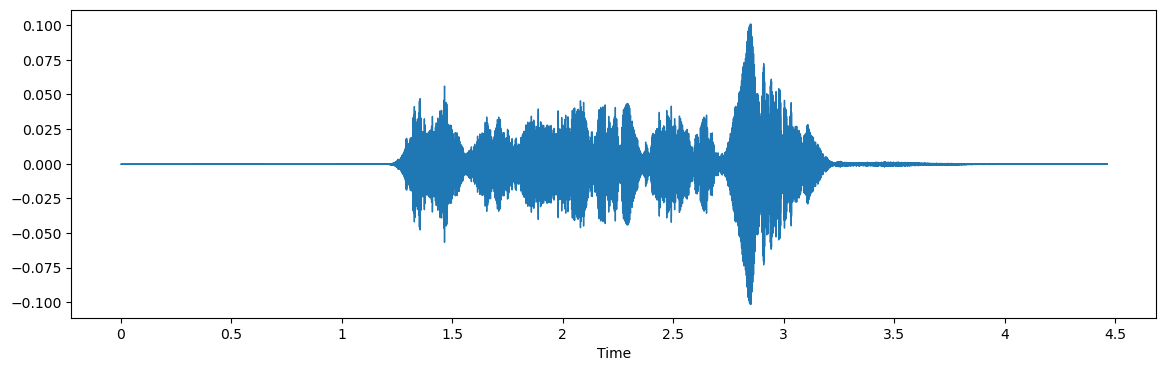

In [66]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

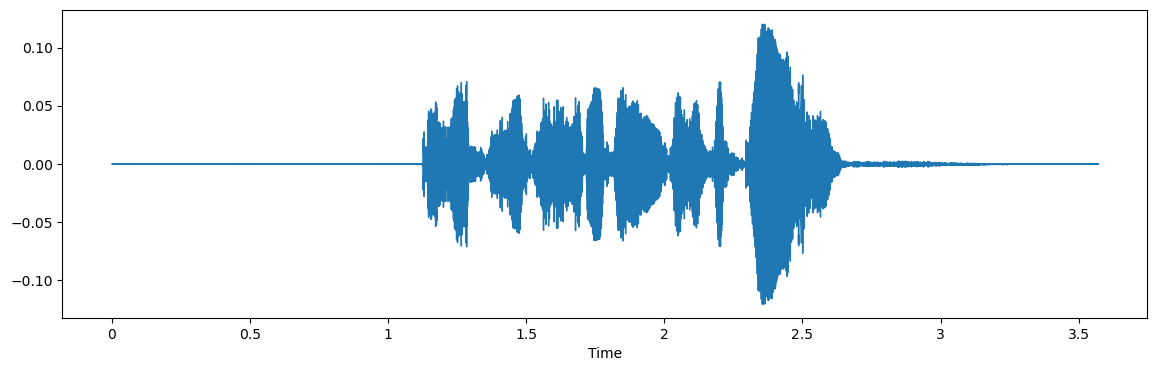

In [67]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

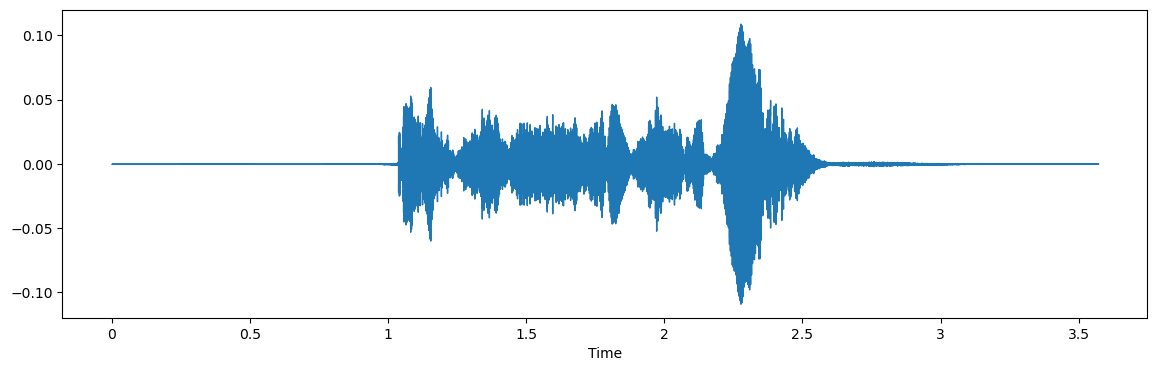

In [68]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [69]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [70]:
X, Y = [], []

#upon further checking, it seems that columns between 1442 and 1465 are assigned to be the the directories, which we don't need. 

# data_path = data_path.drop(data_path.index[1440:1465])

display(data_path)

Emotions                                               Path
0       angry  ./ravdess-emotional-speech-audio/audio_speech_...
1        fear  ./ravdess-emotional-speech-audio/audio_speech_...
2        fear  ./ravdess-emotional-speech-audio/audio_speech_...
3       angry  ./ravdess-emotional-speech-audio/audio_speech_...
4     disgust  ./ravdess-emotional-speech-audio/audio_speech_...
...       ...                                                ...
1435    happy  ./ravdess-emotional-speech-audio/audio_speech_...
1436    happy  ./ravdess-emotional-speech-audio/audio_speech_...
1437     calm  ./ravdess-emotional-speech-audio/audio_speech_...
1438     calm  ./ravdess-emotional-speech-audio/audio_speech_...
1439  neutral  ./ravdess-emotional-speech-audio/audio_speech_...

[1440 rows x 2 columns]

In [71]:
path_emotion_tuple = zip(data_path.Path, data_path.Emotions) # zip returns iterable now, instead of a list, cool! 

for path, emotion in path_emotion_tuple:
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [72]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [73]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.204540  0.529672  0.468962  0.484619  0.554953  0.547627  0.610107   
1  0.304715  0.643028  0.605457  0.613694  0.654627  0.643281  0.670717   
2  0.217951  0.589511  0.491664  0.456409  0.490142  0.556531  0.515801   
3  0.189815  0.560047  0.520643  0.485150  0.440329  0.394749  0.403051   
4  0.326154  0.748576  0.757261  0.754961  0.716567  0.685791  0.611876   

          7         8         9  ...       153       154       155       156  \
0  0.558435  0.531272  0.598957  ...  0.006682  0.004037  0.004855  0.004624   
1  0.595452  0.589749  0.669104  ...  0.007181  0.004450  0.005365  0.005125   
2  0.604818  0.514891  0.525810  ...  0.002848  0.001964  0.000812  0.000931   
3  0.411808  0.440498  0.506417  ...  0.002601  0.002952  0.003851  0.003154   
4  0.583112  0.599765  0.627399  ...  0.003446  0.003740  0.004616  0.004103   

        157       158       159       160       161  labels  
0  0.005723  0.006007  0.006103  0.005150  0.000251   angry  
1  0.006233  0.006652  0.006627  0.005567  0.000750   angry  
2  0.001178  0.000960  0.001344  0.000597  0.000053   angry  
3  0.002964  0.002586  0.002761  0.001653  0.000115    fear  
4  0.003824  0.003516  0.003554  0.002470  0.001065    fear  

[5 rows x 163 columns]

In [74]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [75]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# save this encoder using pickle
import pickle
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [77]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# save this scaler using pickle
import pickle
with open('scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling

In [34]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [35]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])
model.save("complete_model.h5")

Epoch 1/50


51/51 [==============================] - 7s 105ms/step - loss: 2.0045 - accuracy: 0.1966 - val_loss: 1.9481 - val_accuracy: 0.2315 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 5s 105ms/step - loss: 1.9480 - accuracy: 0.2306 - val_loss: 1.9074 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 7s 138ms/step - loss: 1.9004 - accuracy: 0.2429 - val_loss: 1.8458 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 7s 137ms/step - loss: 1.8599 - accuracy: 0.2701 - val_loss: 1.7822 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 7s 133ms/step - loss: 1.8023 - accuracy: 0.2944 - val_loss: 1.7486 - val_accuracy: 0.3574 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 7s 133ms/step - loss: 1.7592 - accuracy: 0.3164 - val_loss: 1.7078 - val_accuracy: 0.3620 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 6s 111ms/step - loss: 1.7132 

 1/34 [..............................] - ETA: 1s - loss: 2.2010 - accuracy: 0.5312

34/34 [==============================] - 0s 11ms/step - loss: 1.2916 - accuracy: 0.6435
Accuracy of our model on test data :  64.35185074806213 %


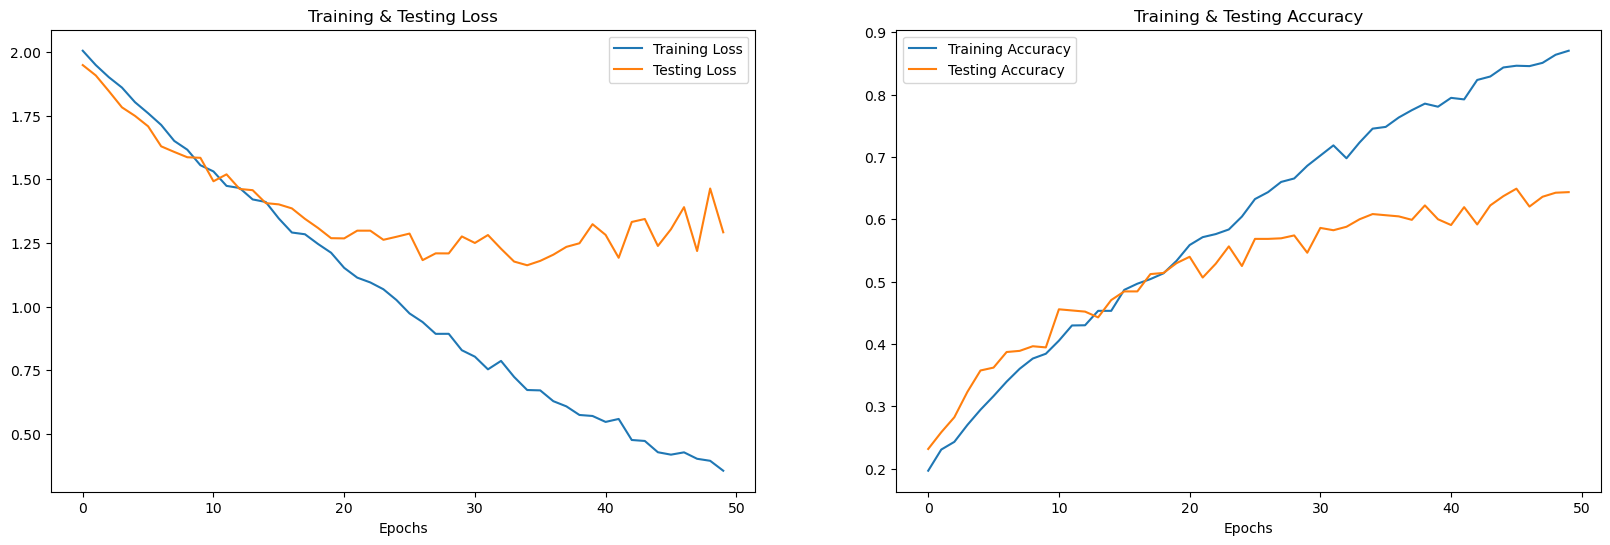

In [36]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [37]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 9ms/step


In [38]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad          fear
1             fear           sad
2            angry         angry
3         surprise         happy
4            happy         happy
5             fear          fear
6              sad          fear
7            happy         happy
8            happy           sad
9             fear          fear

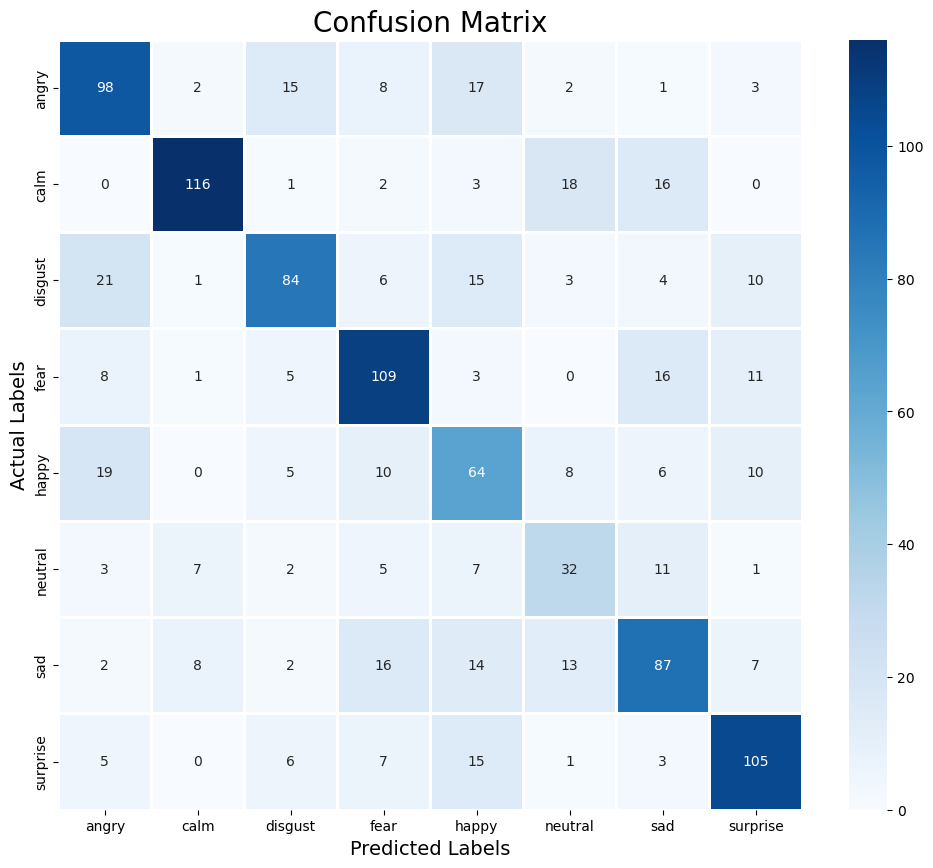

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.67      0.65       146
        calm       0.86      0.74      0.80       156
     disgust       0.70      0.58      0.64       144
        fear       0.67      0.71      0.69       153
       happy       0.46      0.52      0.49       122
     neutral       0.42      0.47      0.44        68
         sad       0.60      0.58      0.59       149
    surprise       0.71      0.74      0.73       142

    accuracy                           0.64      1080
   macro avg       0.63      0.63      0.63      1080
weighted avg       0.65      0.64      0.65      1080



In [41]:
# !pip install pydub
from keras.models import load_model
import librosa
import numpy as np
model = load_model('complete_model.h5')

# convert m4a to wav
john_test_recording = "./testing.wav"

john_test_recording_features = get_features(john_test_recording)

john_test_recording_features = scaler.transform(john_test_recording_features)
john_test_recording_features = np.expand_dims(john_test_recording_features, axis=2)

pred_test = model.predict(john_test_recording_features)
y_pred = encoder.inverse_transform(pred_test) 

y_pred

1/1 [==============================] - 0s 104ms/step


array([['sad'],
       ['sad'],
       ['sad']], dtype=object)

In [42]:
unique_array = np.unique(y_pred)
print(unique_array)

['sad']
